# Analyzing AAPL stock price
Trying to reproduce the results from the paper: Khaidem, Luckyson, Snehanshu Saha, and Sudeepa Roy Dey. "Predicting the direction of stock market prices using random forest." arXiv preprint arXiv:1605.00003 (2016). [paper]

The code used to replicate the paper results was taken from Jose Martinez Heras at https://github.com/jmartinezheras/reproduce-stock-market-direction-random-forests

The first section would be trying to replicate the results from the paper, while the second part will using the model with the new data

In [23]:
#Importing nessesary python packages

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

#Making results reproducible
import random
np.random.seed(42)
random.seed(42)

#Importing packages from sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, precision_score, confusion_matrix, recall_score, accuracy_score
from sklearn.model_selection import train_test_split

#Funtions to do technical indicator calculations
import pandas_techinal_indicators as ta

## Loading Original and New Data

In [25]:
#Original Data
aapl_og = pd.read_csv('RawData/AAPL_Original_Adjusted.csv')

#New data from 2015-2016
aapl_new1 = pd.read_csv('RawData/AAPL_2015_2016.csv')
#New data from 2017-2018
aapl_new2 = pd.read_csv('RawData/AAPL_2017_2018.csv')
#New data from 2017-2018
aapl_new3 = pd.read_csv('RawData/AAPL_2019_2020.csv')

#combining the different dataframes
frames = [aapl_new1,aapl_new2,aapl_new3]
aapl_new = pd.concat(frames)

aapl_new.isnull().values.any()

False

In [26]:
aapl_new.shape

(1479, 7)

In [29]:
aapl_new.dtypes

Date          object
Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume         int64
dtype: object

In [31]:
aapl_new['Date'] = pd.to_datetime(aapl_new['Date'])
aapl_new.dtypes

Date         datetime64[ns]
Open                float64
High                float64
Low                 float64
Close               float64
Adj Close           float64
Volume                int64
dtype: object

In [32]:
aapl_new.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2015-01-02,27.847500,27.860001,26.837500,27.332500,24.696352,212818400
1,2015-01-05,27.072500,27.162500,26.352501,26.562500,24.000614,257142000
2,2015-01-06,26.635000,26.857500,26.157499,26.565001,24.002876,263188400
3,2015-01-07,26.799999,27.049999,26.674999,26.937500,24.339447,160423600
4,2015-01-08,27.307501,28.037500,27.174999,27.972500,25.274624,237458000


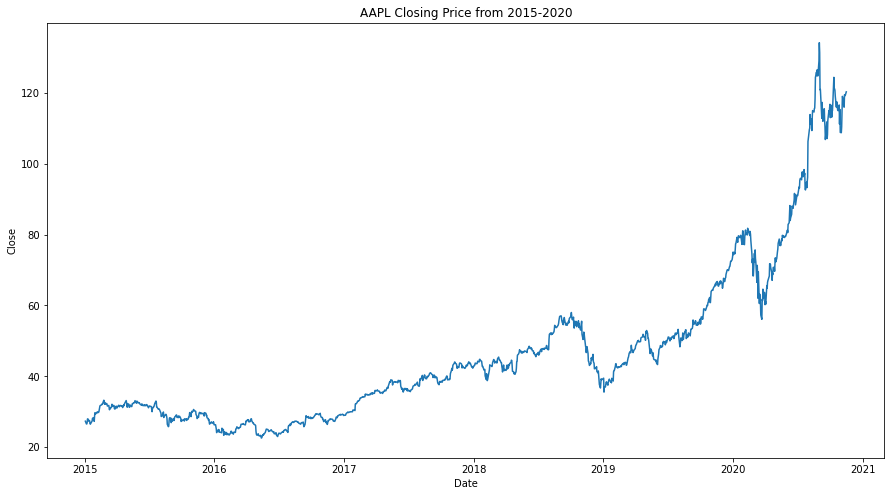

In [44]:
#Plotting new close prices to compare to other charts for data quality
fig, ax = plt.subplots(figsize=(15, 8))
aapl_new_line = sns.lineplot(x='Date', y ='Close', data = aapl_new[['Date','Close']]).set_title('AAPL Closing Price from 2015-2020')
plt.show()

In [22]:
#Removing unessesary columns
del(aapl_og['Date'])
del(aapl_og['Adj Close'])
del(aapl_new['Date'])
del(aapl_new['Adj Close'])

aapl_og.head()

,Open,High,Low,Close,Volume
0,8.410357,8.450357,8.373571,8.392858,430659600
1,8.478929,8.526072,8.312500,8.427500,603145200
2,8.392143,8.518214,8.384643,8.517500,684507600
3,8.507143,8.580000,8.464286,8.555000,447017200
4,8.555357,8.640000,8.523571,8.592857,628502000


## Expontential Smoothing

Using alpha = 0.9 for greater emphasis on more recent data

In [4]:
def get_exp_preprocessing(df, alpha=0.9):
    edata = df.ewm(alpha=alpha).mean()
    return edata

In [5]:
saapl_og = get_exp_preprocessing(aapl_og)
saapl_og.head()

,Open,High,Low,Close,Volume
0,8.410357,8.450357,8.373571,8.392858,4.306596e+08
1,8.472695,8.519189,8.318052,8.424351,5.874647e+08
2,8.400126,8.518311,8.378044,8.508269,6.748907e+08
3,8.496451,8.573837,8.455670,8.550331,4.697840e+08
4,8.549467,8.633384,8.516781,8.588605,6.126316e+08


## Calculating the Values from Technical Analysis

The paper uses formulas created by Peter Bakker at  https://www.quantopian.com/posts/technical-analysis-indicators-without-talib-code

I've analyzed the indicators and it seems like there are a few errors with the calculations, I will try to fix them later but for now, we are just trying to replicate the results

In [6]:
#This takes the formulas from Bakker and adds extra columns to the dataframe with the indicator data, this will be
#our feature matrix (X)
def feature_extraction(data):
    for x in [5, 14, 26, 44, 66]:
        data = ta.relative_strength_index(data, n=x)
        data = ta.stochastic_oscillator_d(data, n=x)
        data = ta.accumulation_distribution(data, n=x)
        data = ta.average_true_range(data, n=x)
        data = ta.momentum(data, n=x)
        data = ta.money_flow_index(data, n=x)
        data = ta.rate_of_change(data, n=x)
        data = ta.on_balance_volume(data, n=x)
        data = ta.commodity_channel_index(data, n=x)
        data = ta.ease_of_movement(data, n=x)
        data = ta.trix(data, n=x)
        data = ta.vortex_indicator(data, n=x)
    
    data['ema50'] = data['Close'] / data['Close'].ewm(50).mean()
    data['ema21'] = data['Close'] / data['Close'].ewm(21).mean()
    data['ema14'] = data['Close'] / data['Close'].ewm(14).mean()
    data['ema5'] = data['Close'] / data['Close'].ewm(5).mean()
        
    #Williams %R is missing
    data = ta.macd(data, n_fast=12, n_slow=26)
    
    del(data['Open'])
    del(data['High'])
    del(data['Low'])
    del(data['Volume'])
    
    return data

#This returns a series that has a one if the price increase or 0 if the price decreases after n number of days
#This column will be the target vector (y)
def compute_prediction_int(df, n):
    pred = (df.shift(-n)['Close'] >= df['Close'])#returns a boolean if the price after a shifted number of days is higher or lower
    pred = pred.iloc[:-n]
    return pred.astype(int)

#This calls the feature_extraction function to add the new indicators to the dataframe as well as the compute_prediction
#that checks if the price increased or decreased after a certian "horizon"
def prepare_data(df, horizon):
    data = feature_extraction(df).dropna().iloc[:-horizon]
    data['pred'] = compute_prediction_int(data, n=horizon)
    del(data['Close'])
    return data.dropna()

## Preparing the Data
In the original notebook, they split the data manually first before using train_test_split, here we are going to go directly to using train test split

The reasoning for not using train test split was data leakage? Need to look into this some more

In [7]:
data = prepare_data(saapl_og, 10)

y = data['pred']

#Not exactly too sure what the author was trying to do in this step
#remove the output from the input
features = [x for x in data.columns if x not in ['gain', 'pred']]
X = data[features]
X.head()

,RSI_5,SO%d_5,Acc/Dist_ROC_5,ATR_5,Momentum_5,MFI_5,ROC_5,OBV_5,CCI_5,EoM_5,...,EoM_66,Trix_66,Vortex_66,ema50,ema21,ema14,ema5,MACD_12_26,MACDsign_12_26,MACDdiff_12_26
196,0.912781,0.727042,-0.136525,0.139337,0.471227,1.0,0.021282,3.217439e+08,1.030952,3.788118e-11,...,6.373460e-12,0.001628,0.266886,1.106229,1.053050,1.039232,1.020300,0.166994,0.139178,0.027816
197,0.969547,0.776262,1.141859,0.172047,0.461123,1.0,0.032454,3.247681e+08,1.607662,4.302690e-11,...,7.179510e-12,0.001634,0.278924,1.122878,1.068111,1.053485,1.031681,0.191716,0.149686,0.042030
198,0.977255,0.666259,-1.220665,0.180520,0.378790,1.0,0.023825,1.721067e+08,1.246925,4.016993e-11,...,7.683809e-12,0.001641,0.289678,1.119684,1.064405,1.049348,1.025920,0.208507,0.161450,0.047057
199,0.977255,0.739163,-10.454762,0.153720,0.372807,1.0,0.031211,1.830402e+08,1.066253,3.459559e-11,...,7.437044e-12,0.001648,0.278619,1.124964,1.068652,1.052990,1.027672,0.226376,0.174435,0.051941
200,0.984948,0.718927,-0.589453,0.135635,0.421389,1.0,0.028717,1.834769e+08,1.019671,3.449549e-11,...,7.346022e-12,0.001657,0.268702,1.126570,1.069400,1.053203,1.026361,0.241735,0.187895,0.053840


In [8]:
y.head()

196    1.0
197    0.0
198    1.0
199    0.0
200    0.0
Name: pred, dtype: float64

In [9]:
#Splitting the data into training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 2*len(X) // 3)

## Training the model and Applying model to data

In [10]:
model = RandomForestClassifier(n_jobs=-1, n_estimators=65, random_state=42)
model.fit(X_train, y_train.values.ravel());

In [11]:
pred = model.predict(X_test)
precision = precision_score(y_pred=pred, y_true=y_test)
recall = recall_score(y_pred=pred, y_true=y_test)
f1 = f1_score(y_pred=pred, y_true=y_test)
accuracy = accuracy_score(y_pred=pred, y_true=y_test)
confusion = confusion_matrix(y_pred=pred, y_true=y_test)
print('precision: {0:1.2f}, recall: {1:1.2f}, f1: {2:1.2f}, accuracy: {3:1.2f}'.format(precision, recall, f1, accuracy))
print('Confusion Matrix')
print(confusion)

precision: 0.84, recall: 0.91, f1: 0.87, accuracy: 0.85
Confusion Matrix
[[113  32]
 [ 16 166]]


The author of the original notebook achieved an accuracy of 87% with this data set while we achieved 85%, a reason for this was because we had to adjusted the data for all the stock splits since this paper was originally published.

In [15]:
aapl_new.shape

(1479, 5)